In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

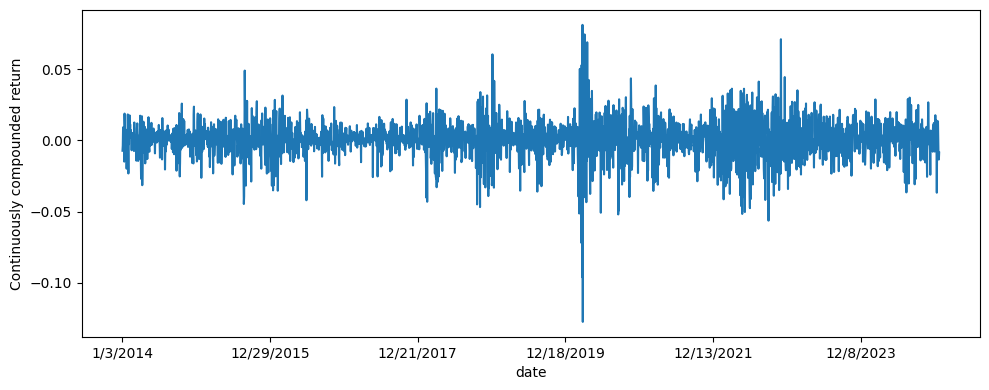

In [75]:
data = pd.read_csv('qqq.csv')
data.set_index('date', inplace=True)

ret = np.log(data['PRC']).diff().dropna()
ret.plot(figsize=(10, 4))
plt.ylabel('Continuously compounded return')
plt.tight_layout()
plt.show()

# part a)

In [76]:
ret = np.log(data['PRC']).diff().dropna()
print('Skewness:', ret.skew())
print('Kurtosis:', ret.kurtosis())

Skewness: -0.5554895752167717
Kurtosis: 7.063258457660907


In [77]:
ret

date
1/3/2014     -0.007245
1/6/2014     -0.003700
1/7/2014      0.009225
1/8/2014      0.002179
1/9/2014     -0.003327
                ...   
12/24/2024    0.013469
12/26/2024   -0.000680
12/27/2024   -0.013382
12/30/2024   -0.013389
12/31/2024   -0.008531
Name: PRC, Length: 2767, dtype: float64

Skewness ≈ −0.56 -> distribution is left skewed. Left tail is longer or heavier meaning large negative returns occur more often.

Kurtosis ≈ 7.06 (excess) -> The distribution has much heavier tails and a sharper peak than a normal distribution. 


Lag 1: 0.4176
Lag 2: 0.4114
Lag 3: 0.2790
Lag 4: 0.2447
Lag 5: 0.2710
Lag 6: 0.2856
Lag 7: 0.1904
Lag 8: 0.2435
Lag 9: 0.1959
Lag 10: 0.2246
Lag 11: 0.1685
Lag 12: 0.1537
Lag 13: 0.1413
Lag 14: 0.1499
Lag 15: 0.1665
Lag 16: 0.1261
Lag 17: 0.1089
Lag 18: 0.0857
Lag 19: 0.0613
Lag 20: 0.1187


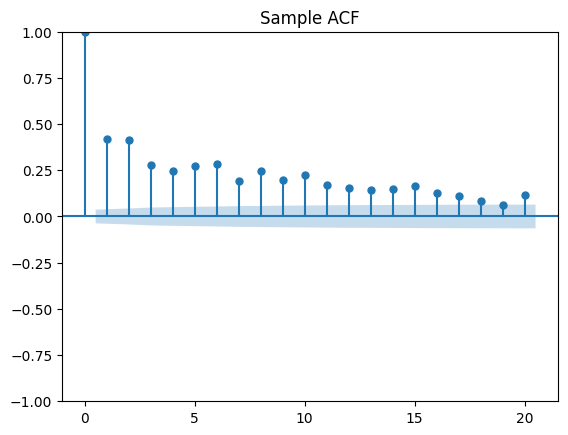

In [78]:
squared_ret = ret ** 2
acf_sq = acf(squared_ret.dropna(), nlags=20)

plot_acf(squared_ret, lags=20, alpha=0.05, title=f'Sample ACF')
# acf_sq[0] is lag 0 (always 1); report lags 1–20
for lag in range(1, 21):
    print(f"Lag {lag}: {acf_sq[lag]:.4f}")


Autocorrelations are positive at every lag and substantial at short lags. Squared returns here are serially correlated

# b)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# ret = np.log(data['PRC']).diff().dropna()  # your returns

/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


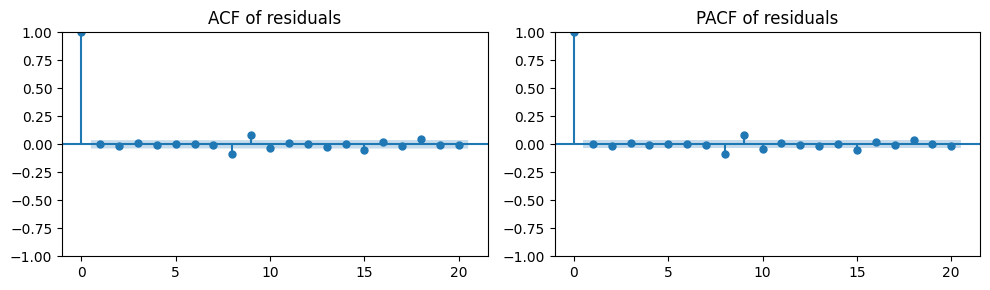

In [80]:
# Fit ARMA(p,q) - try (0,0), (1,0), (0,1), (1,1) and pick via AIC/BIC + diagnostics
model_arma = ARIMA(ret, order=(7, 0, 1))  # or (1,0,0), (0,1,0), (1,1,0)
res_arma = model_arma.fit()
eps = res_arma.resid.dropna()

# Residual diagnostics: ACF and Ljung-Box on residuals
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(eps, lags=20, ax=axes[0], title='ACF of residuals')
plot_pacf(eps, lags=20, ax=axes[1], title='PACF of residuals')
plt.tight_layout()
plt.show()

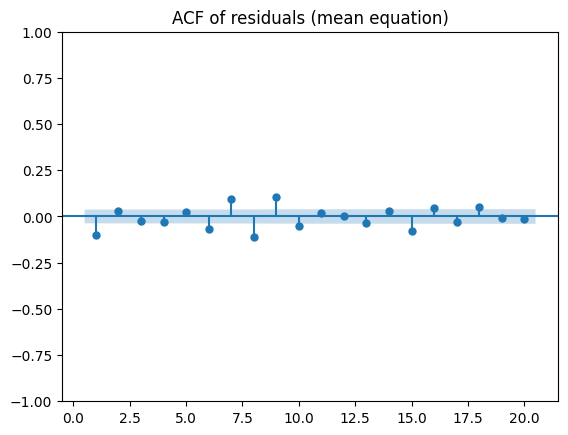

In [81]:
# Fit constant mean + GARCH(1,1)
m0 = arch_model(ret * 100, mean='Constant', vol='GARCH', p=1, q=1)  # scale if needed
fit0 = m0.fit(disp='off')
eps = fit0.resid
eps2 = eps ** 2

# Residual diagnostics (for mean): ACF of residuals
plot_acf(eps, lags=20, zero=False)
plt.title('ACF of residuals (mean equation)')
plt.show()

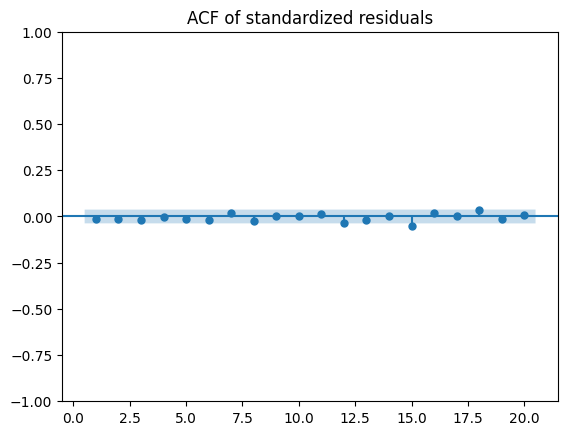

In [82]:
plot_acf(fit0.std_resid, lags=20, zero=False)
plt.title('ACF of standardized residuals')
plt.show()

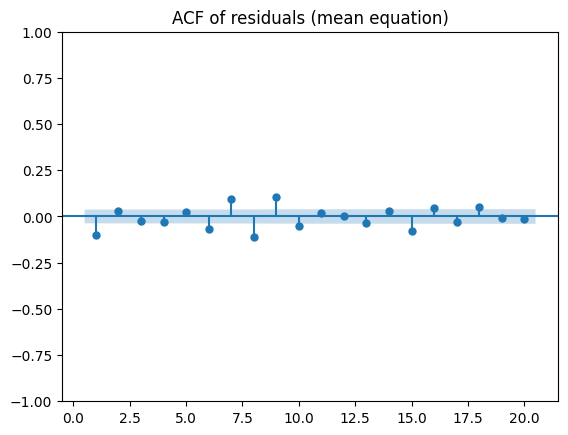

In [83]:
# Final model (example: AR(1) mean + GARCH(1,1))
model = arch_model(ret * 100, mean='AR', lags=10, vol='GARCH', p=1, q=1)
result = model.fit(disp='off')

fit0 = m0.fit(disp='off')
eps = fit0.resid
eps2 = eps ** 2

# Residual diagnostics (for mean): ACF of residuals
plot_acf(eps, lags=20, zero=False)
plt.title('ACF of residuals (mean equation)')
plt.show()

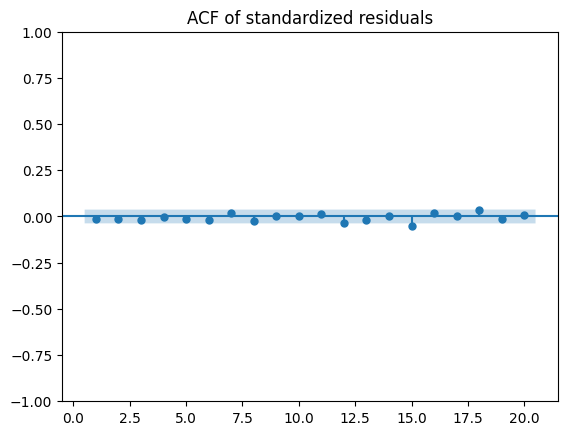

In [84]:
plot_acf(fit0.std_resid, lags=20, zero=False)
plt.title('ACF of standardized residuals')
plt.show()

# c)

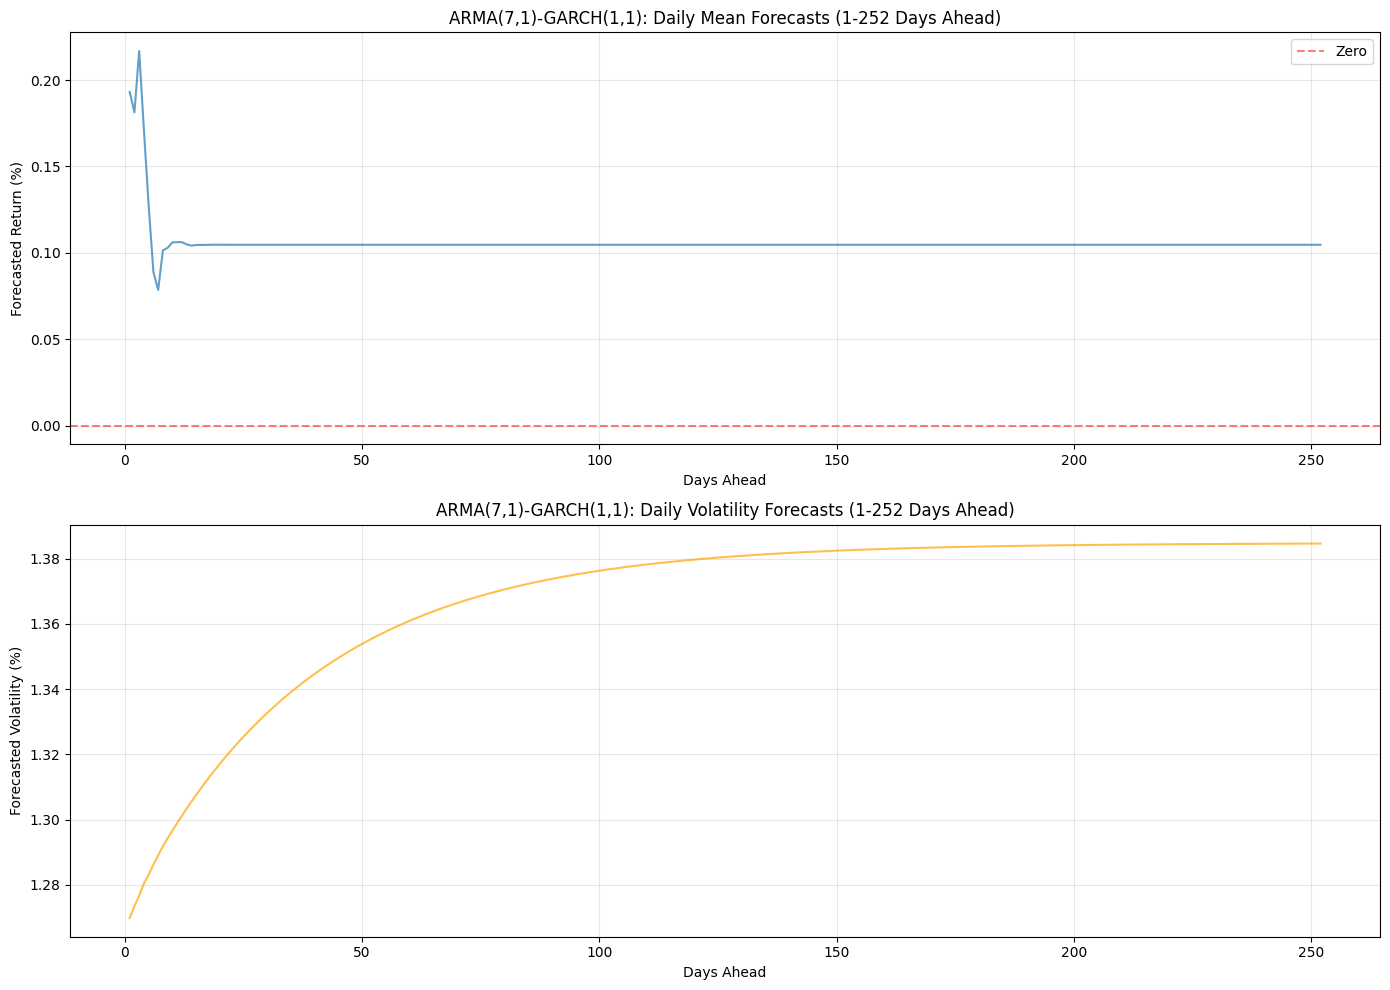


Forecasts at Monthly Intervals:
    Days Ahead  Month  Mean Forecast (%)  Volatility Forecast (%)
0           21      1           0.104640                 1.318876
1           42      2           0.104645                 1.346739
2           63      3           0.104645                 1.362730
3           84      4           0.104645                 1.371971
4          105      5           0.104645                 1.377334
5          126      6           0.104645                 1.380452
6          147      7           0.104645                 1.382268
7          168      8           0.104645                 1.383326
8          189      9           0.104645                 1.383943
9          210     10           0.104645                 1.384302
10         231     11           0.104645                 1.384512
11         252     12           0.104645                 1.384635


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming you have ret (returns) already defined
# Fit ARMA(7,1) + GARCH(1,1)
model = arch_model(ret * 100, mean='AR', lags=7, vol='GARCH', p=1, q=1, dist='normal')
fit = model.fit(disp='off')

# Generate forecasts from the last observation: 1 day through 252 days (12 months)
forecasts = fit.forecast(horizon=252, start=len(ret)-1)

# Extract mean forecasts (point forecasts) - all 252 days
mean_forecast = forecasts.mean.iloc[-1]  # Last row = forecasts from last day

# Extract variance forecasts (volatility forecasts) - all 252 days
variance_forecast = forecasts.variance.iloc[-1]
vol_forecast = np.sqrt(variance_forecast)  # Convert variance to volatility

# Days ahead: 1, 2, 3, ..., 252
days_ahead = np.arange(1, 253)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Mean forecasts (point forecasts) - daily
ax1.plot(days_ahead, mean_forecast.values, linewidth=1.5, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero')
ax1.set_xlabel('Days Ahead')
ax1.set_ylabel('Forecasted Return (%)')
ax1.set_title('ARMA(7,1)-GARCH(1,1): Daily Mean Forecasts (1-252 Days Ahead)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Volatility forecasts - daily
ax2.plot(days_ahead, vol_forecast.values, linewidth=1.5, color='orange', alpha=0.7)
ax2.set_xlabel('Days Ahead')
ax2.set_ylabel('Forecasted Volatility (%)')
ax2.set_title('ARMA(7,1)-GARCH(1,1): Daily Volatility Forecasts (1-252 Days Ahead)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Print summary at monthly intervals for reference
monthly_days = [21, 42, 63, 84, 105, 126, 147, 168, 189, 210, 231, 252]
print("\nForecasts at Monthly Intervals:")
print(pd.DataFrame({
    'Days Ahead': monthly_days,
    'Month': np.arange(1, 13),
    'Mean Forecast (%)': mean_forecast.iloc[[d-1 for d in monthly_days]].values,
    'Volatility Forecast (%)': vol_forecast.iloc[[d-1 for d in monthly_days]].values
}))

# d)

In [86]:
# One year = 252 trading days
H = 252
f = res.forecast(horizon=H, reindex=False)

# Variance forecasts: (1, H) -> 1-step through H-step ahead from last day
var_fcast = f.variance.values[-1]   # shape (252,)

# Cumulated forecasted variance for the next year
var_next_year = var_fcast.sum()
vol_next_year = np.sqrt(var_next_year)   # forecasted vol of 1-year cumulative return

print(f"Forecasted variance (next year): {var_next_year:.6f}")
print(f"Forecasted vol of 1-year return: {vol_next_year:.4f} ({vol_next_year:.2%})")

Forecasted variance (next year): 473.285352
Forecasted vol of 1-year return: 21.7551 (2175.51%)


In [87]:
# Example: ret_index and ret_stock are your return series (e.g. log-differenced)
# Scale if you fit on scaled data (e.g. * 100)

ret_index = ret

def cumulated_annual_variance(ret_series, mean_spec='AR', ar_lags=10):
    """Fit AR-GARCH(1,1), return cumulated 252-day forecasted variance."""
    y = ret_series * 100
    model = arch_model(y, mean=mean_spec, lags=ar_lags if mean_spec == 'AR' else None,
                      vol='GARCH', p=1, q=1)
    res = model.fit(disp='off')
    f = res.forecast(horizon=252, reindex=False)
    return f.variance.values[-1].sum()

# Index (e.g. QQQ)
var_index = cumulated_annual_variance(ret_index, mean_spec='AR', ar_lags=10)
# Stock
# var_stock = cumulated_annual_variance(ret_stock, mean_spec='AR', ar_lags=10)

print("Forecasted variance for next year:")
print(f"  Index: {var_index:.6f}  (vol = {np.sqrt(var_index):.4f})")
# print(f"  Stock: {var_stock:.6f}  (vol = {np.sqrt(var_stock):.4f})")

Forecasted variance for next year:
  Index: 470.671129  (vol = 21.6950)
